In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import ipyvolume as ipv
from ipywidgets import FloatProgress
from IPython.display import display, Image


from tyssue import Sheet
from tyssue.draw import sheet_view, browse_history
from tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom
from tyssue.io import hdf5
from tyssue.dynamics import model_factory, effectors
from tyssue.generation.shapes import spherical_sheet

from tyssue.behaviors import EventManager
from tyssue.behaviors import increase, decrease, reconnect
from tyssue.solvers.viscous import EulerSolver
from tyssue.utils.decorators import face_lookup


from tyssue.draw import highlight_faces, create_gif
from tyssue.solvers.quasistatic import QSSolver

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units


from tyssue import HistoryHdf5



Reference: https://elifesciences.org/articles/32943



I count approx 60 cells in a perimeter of the spherical follicle at stage 5


That means we have a radius of $R = 60 / 2\pi \approx 10$ cells, and $4\pi R^2$ or about 1200 cells in total over the follicle surface.

It is conveninent to consider that cells have an average surface of 1

In [2]:
follicle = spherical_sheet(10., 1200)

geom.update_all(follicle)
geom.scale(follicle, follicle.face_df.area.mean()**(-0.5), list("xyz"))
geom.update_all(follicle)

print(f"Follicle has {follicle.Nf} cells")

Follicle has 1273 cells


In [3]:
draw_specs = {
    'edge': {
        'visible': True,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}


In [4]:
ipv.clear()

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


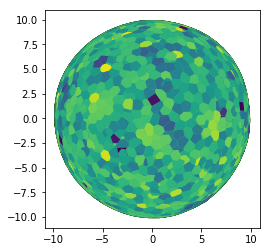

In [10]:
fig, ax = sheet_view(follicle, mode="2D", coords=["z", "x"], **draw_specs)
fig.set_size_inches(8, 8)

In [11]:
model = model_factory([
    effectors.LumenVolumeElasticity,
    effectors.FaceAreaElasticity,
    effectors.PerimeterElasticity,
    ])

In [12]:
specs = {
    'face': {
        'is_alive': 1,
        'area_elasticity': 1.0,
        'prefered_area': 1.0,
        'perimeter_elasticity': 0.1,
        'prefered_perimeter': 3.6
    },
    'settings': {
        'lumen_vol_elasticity': 1e-1/ follicle.Nf,
        'lumen_prefered_vol': follicle.settings['lumen_vol'],
    }
}

follicle.update_specs(specs, reset=True)




Reseting column is_alive of the face dataset with new specs
Reseting column area_elasticity of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column perimeter_elasticity of the face dataset with new specs
Reseting column prefered_perimeter of the face dataset with new specs


In [13]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)

ipv.clear()

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [16]:
def contractility_grad(z, z_a=10, ant_increase=6, post_increase=6):
    """Returns the amplitude of the gradient for z 
    (along the posterior-anterior axis of the follicle).
    
    The gradient is modeled as a quadratic function of z, such that the increase in
    contractility is equal to ant_increase at z_a and to post_increase at -z_a.
    
    """
    
    # we look for a quadradic function with C(-z_a) = ant_increase, C(z_a) = post_increase
    # and C(z_min) = 0 - we find the correct coefs p2, p1 and p0 bellow
    
    app = ant_increase + post_increase
    amp = ant_increase - post_increase
    if amp == 0.:
        p2 = ant_increase / z_a**2
        p1 = 0
        p0 = 0
    else:
        p1 = amp / (2 * z_a)
        inv_poly = [2*z_a**2, -app, p1**2]
        p2_0, p2_1 = np.poly1d(inv_poly).roots
        if isinstance(p2_0, np.complex):
            p2_0, p2_1 = np.real([p2_0, p2_1])
        p2 = p2_0 if p2_0 >= 0 else p2_1
        p0 = p1**2 / (4*p2)

    poly = np.poly1d([p2, p1, p0])
    return np.polyval(poly, z)




In [17]:
follicle.face_df["contractile_grad"] = 1 + contractility_grad(follicle.face_df.z)
follicle.face_df["prefered_area"] /= follicle.face_df["contractile_grad"]
follicle.face_df["prefered_perimeter"] /= follicle.face_df["contractile_grad"]**0.5


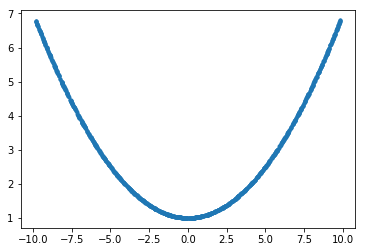

In [18]:
fig, ax = plt.subplots()
ax.plot(follicle.face_df['z'], follicle.face_df['contractile_grad'], '.')

In [19]:
draw_specs = {
    'edge': {
        'visible': True,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['contractile_grad']
    },
}


In [20]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)

ipv.clear()

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

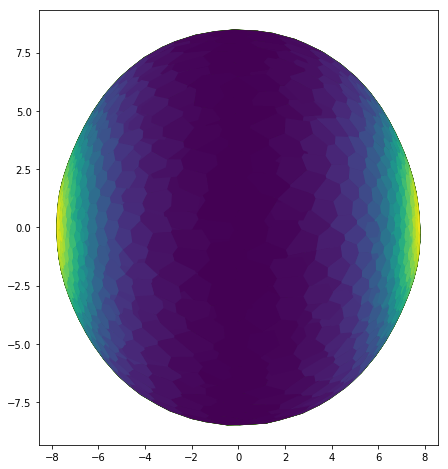

In [21]:
fig, ax = sheet_view(follicle, mode="2D", coords=["z", "x"], **draw_specs)
fig.set_size_inches(8, 8)